## KNN on Pima Indians Diabetes Dataset

In [5]:
!wget https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv

/bin/bash: wget: command not found


Import libraries

In [136]:
import pandas as pd
import numpy as np

import graphviz 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)

import math

from sklearn.model_selection import train_test_split
import random
from sklearn.model_selection import GridSearchCV 

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

#! pip install -U eli5
import eli5
from eli5.sklearn import PermutationImportance

#! pip install -U shap
import shap

In [137]:
# Metrics to assess performance
import collections
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn import metrics

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html

In [7]:
from sklearn.preprocessing import StandardScaler

rawdata = pd.read_csv("diabetes.csv", header=0, encoding='utf-8')
sub = (rawdata['Glucose'] != 0) & (rawdata['BloodPressure'] != 0) & (rawdata['BMI'] != 0)

X = rawdata[sub].copy()

print(X.head())
print(X.shape)
y = X['Outcome']
X.drop(columns='Outcome', inplace=True)
print(X.shape)

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
(724, 9)
(724, 8)


In [8]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X))

X_scaled.columns = X.columns
X_scaled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.635022,0.849933,-0.032378,0.862278,-0.722572,0.164562,0.458421,1.416075
1,-0.852861,-1.200262,-0.517370,0.480644,-0.722572,-0.852262,-0.372691,-0.199947
2,1.230175,1.988930,-0.679035,-1.363918,-0.722572,-1.331622,0.593928,-0.114893
3,-0.852861,-1.070091,-0.517370,0.099010,0.081288,-0.634371,-0.926765,-1.050485
4,-1.150438,0.491962,-2.619006,0.862278,0.714115,1.544537,5.460146,-0.029839


[0.254 0.233 0.127 0.11  0.102 0.07  0.053 0.05 ]


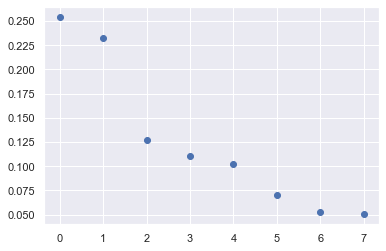

In [9]:
pca = PCA()
pca.fit(X_scaled)
print(pca.explained_variance_ratio_.round(3))
plt.plot(pca.explained_variance_ratio_, 'o')

In [160]:
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
from sklearn.decomposition import PCA
from sklearn.neighbors import (KNeighborsClassifier, NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

pca = PCA()
scaler = StandardScaler()
knn = KNeighborsClassifier()
nca = NeighborhoodComponentsAnalysis()

pipe = Pipeline(steps=[('scaler', scaler), ('knn', knn)])
pipe_pca = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('knn', knn)])
pipe_nca = Pipeline(steps=[('scaler', scaler), ('nca', nca), ('knn', knn)])

In [13]:
print(pipe.get_params().keys())

params  = {'knn__n_neighbors': [40, 50, 60],
           'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
           'knn__p': [1.5, 2.5],
           'knn__weights': ['uniform', 'distance']
          }

params_nca  = {'nca__n_components': [2, 6, 8],
           'knn__n_neighbors': [ 40, 50, 60],
           'knn__p': [1.5, 2.5],
           'knn__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
           'knn__weights': ['uniform', 'distance']
          }

params_pca  = {'pca__n_components': [2, 6, 8],
           'knn__n_neighbors': [40, 50, 60],
           'knn__p': [1.5, 2.5],
           'knn__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
           'knn__weights': ['uniform', 'distance']
          }

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'knn', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'knn__algorithm', 'knn__leaf_size', 'knn__metric', 'knn__metric_params', 'knn__n_jobs', 'knn__n_neighbors', 'knn__p', 'knn__weights'])


In [14]:
cv = GridSearchCV(pipe, params, scoring='roc_auc', cv=5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
                         'knn__n_neighbors': [40, 50, 60], 'knn__p': [1.5, 2.5],
                         'knn__weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [255]:
cv_nca = GridSearchCV(pipe_nca, params_nca, scoring='roc_auc', cv=5)
cv_nca.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('nca',
                                        NeighborhoodComponentsAnalysis()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'chebyshev',
                                         'minkowski'],
                         'knn__n_neighbors': [40, 50, 60],
                         'knn__p': [1.5, 2.5, 3.5, 4.5],
                         'knn__weights': ['uniform', 'distance'],
                         'nca__n_components': [2, 6, 8]},
             scoring='roc_auc')

In [256]:
cv_pca = GridSearchCV(pipe_pca, params_pca, scoring='roc_auc', cv=5)
cv_pca.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'chebyshev',
                                         'minkowski'],
                         'knn__n_neighbors': [40, 50, 60],
                         'knn__p': [1.5, 2.5, 3.5, 4.5],
                         'knn__weights': ['uniform', 'distance'],
                         'pca__n_components': [2, 6, 8]},
             scoring='roc_auc')

In [257]:
pd.DataFrame(cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__p,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
39,0.002793,0.000283,0.003831,0.000455,manhattan,50,4.5,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.895285,0.818211,0.875329,0.815954,0.827333,0.846422,0.032593,1
37,0.003019,0.000440,0.004106,0.000414,manhattan,50,3.5,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.895285,0.818211,0.875329,0.815954,0.827333,0.846422,0.032593,1
35,0.002489,0.000163,0.003621,0.000316,manhattan,50,2.5,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.895285,0.818211,0.875329,0.815954,0.827333,0.846422,0.032593,1
33,0.002792,0.000253,0.003697,0.000377,manhattan,50,1.5,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.895285,0.818211,0.875329,0.815954,0.827333,0.846422,0.032593,1
46,0.002832,0.000274,0.003950,0.000184,manhattan,60,4.5,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.895447,0.826992,0.877303,0.814309,0.816167,0.846044,0.033706,5


In [258]:
pd.DataFrame(cv_nca.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__p,param_knn__weights,param_nca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
192,0.288867,0.039316,0.004138,0.000337,chebyshev,60,1.5,uniform,2,"{'knn__metric': 'chebyshev', 'knn__n_neighbors...",0.897724,0.820813,0.883224,0.790132,0.844,0.847178,0.039531,1
210,0.280941,0.054025,0.004196,0.000293,chebyshev,60,4.5,uniform,2,"{'knn__metric': 'chebyshev', 'knn__n_neighbors...",0.897724,0.820813,0.883224,0.790132,0.844,0.847178,0.039531,1
204,0.266226,0.043787,0.003978,0.000575,chebyshev,60,3.5,uniform,2,"{'knn__metric': 'chebyshev', 'knn__n_neighbors...",0.897724,0.820813,0.883224,0.790132,0.844,0.847178,0.039531,1
198,0.237546,0.041337,0.003678,0.000273,chebyshev,60,2.5,uniform,2,"{'knn__metric': 'chebyshev', 'knn__n_neighbors...",0.897724,0.820813,0.883224,0.790132,0.844,0.847178,0.039531,1
282,0.334024,0.056692,0.006801,0.000629,minkowski,60,4.5,uniform,2,"{'knn__metric': 'minkowski', 'knn__n_neighbors...",0.896585,0.818049,0.882895,0.790789,0.847,0.847064,0.039357,5


In [259]:
pd.DataFrame(cv_pca.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__p,param_knn__weights,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
245,0.003575,0.000161,0.012796,0.000463,minkowski,50,1.5,distance,8,"{'knn__metric': 'minkowski', 'knn__n_neighbors...",0.893333,0.820488,0.858553,0.794408,0.824667,0.838290,0.034259,1
281,0.003200,0.000244,0.011325,0.000383,minkowski,60,3.5,distance,8,"{'knn__metric': 'minkowski', 'knn__n_neighbors...",0.903740,0.808455,0.856250,0.795066,0.824333,0.837569,0.038876,2
221,0.004112,0.000284,0.012371,0.000341,minkowski,40,1.5,distance,8,"{'knn__metric': 'minkowski', 'knn__n_neighbors...",0.897236,0.818862,0.860855,0.787829,0.823000,0.837556,0.037785,3
269,0.003313,0.000289,0.012319,0.000502,minkowski,60,1.5,distance,8,"{'knn__metric': 'minkowski', 'knn__n_neighbors...",0.892683,0.818537,0.862500,0.787500,0.826000,0.837444,0.036502,4
275,0.003141,0.000169,0.011824,0.000547,minkowski,60,2.5,distance,8,"{'knn__metric': 'minkowski', 'knn__n_neighbors...",0.898211,0.810081,0.859868,0.793092,0.825667,0.837384,0.037550,5


max CV ROC AUC is 0.8306854380512917

best params are {'knn__metric': 'minkowski', 'knn__n_neighbors': 60, 'knn__p': 1.5, 'knn__weights': 'distance'}

accuracy is 0.7862068965517242

ROC AUC is 0.679890560875513

              precision    recall  f1-score   support

 No Diabetes       0.79      0.94      0.86       102
    Diabetes       0.75      0.42      0.54        43

    accuracy                           0.79       145
   macro avg       0.77      0.68      0.70       145
weighted avg       0.78      0.79      0.77       145




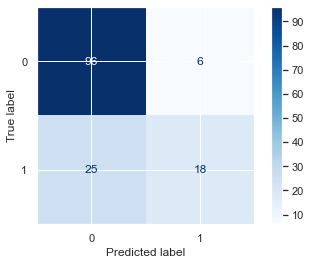

In [15]:
from sklearn.metrics import roc_auc_score

knn_best = cv.best_estimator_
print('max CV ROC AUC is {}\n'.format(cv.best_score_))

print('best params are {}\n'.format(cv.best_params_))

y_pred = knn_best.fit(X_train, y_train).predict(X_test)
print('accuracy is {}\n'.format(knn_best.score(X_test, y_test)))

print('ROC AUC is {}\n'.format(roc_auc_score(y_test, y_pred)))

print('{}\n'.format(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes'])))
plot_confusion_matrix(knn_best, X_test, y_test, cmap=plt.cm.Blues)

max CV ROC AUC is 0.8471783697047497

best params are {'knn__metric': 'chebyshev', 'knn__n_neighbors': 60, 'knn__p': 1.5, 'knn__weights': 'uniform', 'nca__n_components': 2}

accuracy is 0.7103448275862069

ROC AUC is 0.6528441163699522

              precision    recall  f1-score   support

 No Diabetes       0.77      0.82      0.79        98
    Diabetes       0.56      0.49      0.52        47

    accuracy                           0.71       145
   macro avg       0.67      0.65      0.66       145
weighted avg       0.70      0.71      0.70       145




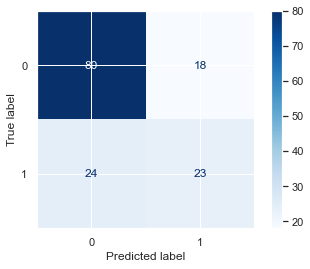

In [273]:
from sklearn.metrics import roc_auc_score

knn_nca_best = cv_nca.best_estimator_
print('max CV ROC AUC is {}\n'.format(max(cv_nca.cv_results_['mean_test_score'])))

print('best params are {}\n'.format(cv_nca.best_params_))

y_pred = knn_nca_best.fit(X_train, y_train).predict(X_test)
print('accuracy is {}\n'.format(knn_nca_best.score(X_test, y_test)))

print('ROC AUC is {}\n'.format(roc_auc_score(y_test, y_pred)))

print('{}\n'.format(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes'])))
plot_confusion_matrix(knn_nca_best, X_test, y_test, cmap=plt.cm.Blues)

max CV ROC AUC is 0.8382896662387676

best params are {'knn__metric': 'minkowski', 'knn__n_neighbors': 50, 'knn__p': 1.5, 'knn__weights': 'distance', 'pca__n_components': 8}

accuracy is 0.7379310344827587

ROC AUC is 0.6455709943551888

              precision    recall  f1-score   support

 No Diabetes       0.75      0.91      0.82        98
    Diabetes       0.67      0.38      0.49        47

    accuracy                           0.74       145
   macro avg       0.71      0.65      0.66       145
weighted avg       0.73      0.74      0.71       145




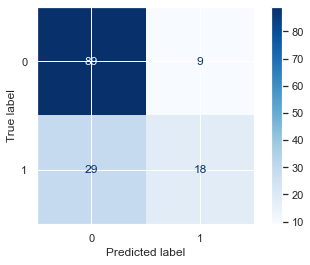

In [274]:
from sklearn.metrics import roc_auc_score

knn_pca_best = cv_pca.best_estimator_
print('max CV ROC AUC is {}\n'.format(max(cv_pca.cv_results_['mean_test_score'])))

print('best params are {}\n'.format(cv_pca.best_params_))

y_pred = knn_pca_best.fit(X_train, y_train).predict(X_test)
print('accuracy is {}\n'.format(knn_pca_best.score(X_test, y_test)))

print('ROC AUC is {}\n'.format(roc_auc_score(y_test, y_pred)))

print('{}\n'.format(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes'])))
plot_confusion_matrix(knn_pca_best, X_test, y_test, cmap=plt.cm.Blues)

In [33]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_scaled, y, test_size=0.2)

In [28]:
cv.best_params_

{'knn__metric': 'minkowski',
 'knn__n_neighbors': 60,
 'knn__p': 1.5,
 'knn__weights': 'distance'}

In [34]:
knn = KNeighborsClassifier(n_neighbors=60, metric='minkowski', p=1.5, weights='distance')
knn.fit(Xs_train, ys_train)

KNeighborsClassifier(n_neighbors=60, p=1.5, weights='distance')

In [128]:
import shap  # package used to calculate Shap values

X_train_summary = shap.kmeans(X_train, 10)

# Create object that can calculate shap values
explainer = shap.KernelExplainer(knn.predict_proba, X_train_summary)

# Calculate Shap values
shap_values = explainer.shap_values(Xs_test.iloc[:10])

  0%|          | 0/10 [00:00<?, ?it/s]

In [129]:
Xs_test.iloc[0]

Pregnancies                -1.150438
Glucose                     1.858759
BloodPressure               1.422601
SkinThickness               0.353433
Insulin                    -0.722572
BMI                         1.689797
DiabetesPedigreeFunction    0.636086
Age                        -0.880377
Name: 224, dtype: float64

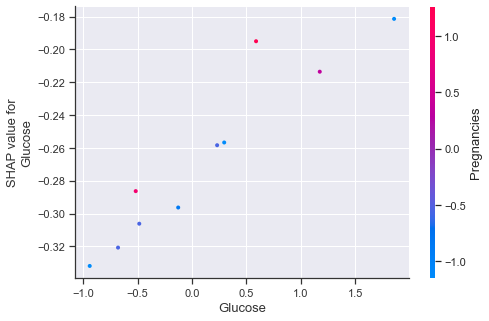

In [132]:
shap.initjs()
shap.dependence_plot("Glucose", shap_values[1], Xs_test.iloc[:10])

In [134]:
shap.initjs()
shap.force_plot(explainer.expected_value[1],
                shap_values[1],
                Xs_test)

In [111]:
Xs_train.median().values.reshape((1, X_train.shape[1]))

array([[-0.25770788, -0.15889325, -0.03237751,  0.16261597, -0.26933163,
        -0.03880302, -0.28235263, -0.3700545 ]])

In [113]:
f = lambda x: knn.predict_proba(x)[:, 1]
med = Xs_train.median().values.reshape((1, X_train.shape[1]))
explainer = shap.KernelExplainer(f, med)

In [113]:
shap_values_single = explainer.shap_values(X.iloc[0,:], nsamples=1000)
shap.force_plot(explainer.expected_value, shap_values_single, Xs_train.iloc[0,:])

In [122]:
shap_values = explainer.shap_values(Xs_test.iloc[0:100, :], nsamples=1000)
shap.force_plot(explainer.expected_value, shap_values, Xs_test.iloc[0:100,:])

  0%|          | 0/100 [00:00<?, ?it/s]

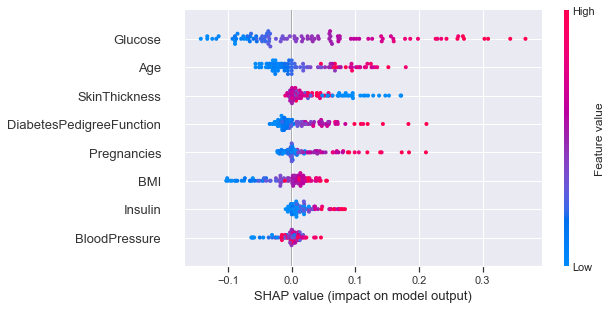

In [124]:
shap.summary_plot(shap_values, Xs_test.iloc[0:100, :])

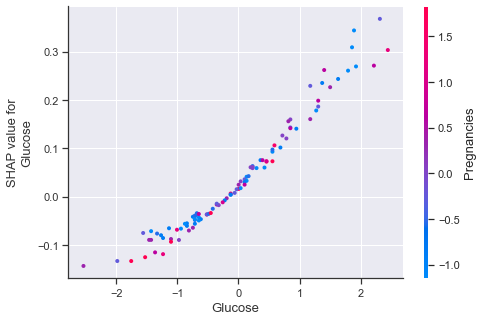

In [126]:
shap.dependence_plot("Glucose", shap_values, Xs_test.iloc[:100,:])

<AxesSubplot:>

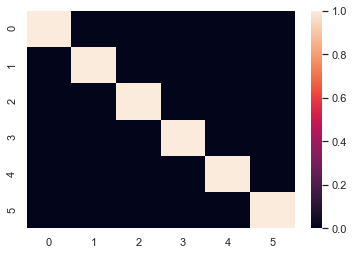

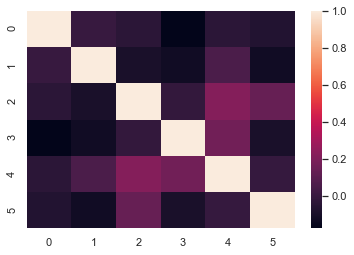

In [92]:
pca = PCA(n_components=6, whiten=True)
pca.fit(X_train)

X_train_pca = pd.DataFrame(pca.transform(X_train))
X_test_pca = pd.DataFrame(pca.transform(X_test))

plt.figure()
sns.heatmap(X_train_pca.corr())
plt.figure()
sns.heatmap(X_test_pca.corr())

In [162]:
params  = {'n_neighbors': [10, 20, 30, 40, 50],
           'metric': ['euclidean', 'manhattan', 'chebyshev'],
           'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
cv = GridSearchCV(knn, params, scoring='roc_auc', cv=5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': [10, 20, 30, 40, 50],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [163]:
pd.DataFrame(cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,0.001399,0.000075,0.003318,0.000241,manhattan,50,distance,"{'metric': 'manhattan', 'n_neighbors': 50, 'we...",0.890407,0.818537,0.877961,0.817599,0.829333,0.846767,0.031078,1
16,0.001608,0.000283,0.003586,0.000329,manhattan,40,uniform,"{'metric': 'manhattan', 'n_neighbors': 40, 'we...",0.891870,0.815122,0.879441,0.818092,0.827833,0.846472,0.032507,2
18,0.001445,0.000121,0.003432,0.000148,manhattan,50,uniform,"{'metric': 'manhattan', 'n_neighbors': 50, 'we...",0.887967,0.815935,0.880428,0.819901,0.827500,0.846346,0.031219,3
17,0.001569,0.000279,0.003216,0.000117,manhattan,40,distance,"{'metric': 'manhattan', 'n_neighbors': 40, 'we...",0.891057,0.816260,0.875987,0.814967,0.828667,0.845388,0.031860,4
14,0.001386,0.000075,0.002911,0.000194,manhattan,30,uniform,"{'metric': 'manhattan', 'n_neighbors': 30, 'we...",0.886992,0.811707,0.866776,0.823191,0.826667,0.843067,0.028771,5


[0.81462749 0.81707832 0.83270753 0.83226579 0.83398251 0.83503299
 0.83287673 0.8360884  0.83328243 0.83570456 0.80913822 0.80815924
 0.83606536 0.83631883 0.84150306 0.84150246 0.84473603 0.84341069
 0.84517171 0.84642243 0.80114309 0.80549121 0.81565135 0.81980947
 0.81824791 0.82177691 0.82354017 0.82519069 0.82326149 0.8263659 ]
make_scorer(roc_auc_score, needs_threshold=True)
0.7448275862068966
              precision    recall  f1-score   support

 No Diabetes       0.76      0.92      0.83        98
    Diabetes       0.69      0.38      0.49        47

    accuracy                           0.74       145
   macro avg       0.72      0.65      0.66       145
weighted avg       0.74      0.74      0.72       145



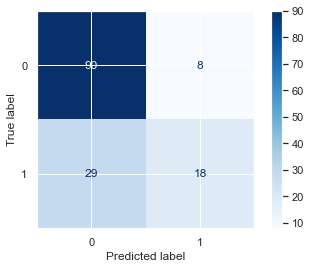

In [198]:
knn_best = cv.best_estimator_
print(cv.scorer_)

y_pred = knn_best.fit(X_train, y_train).predict(X_test)
print(knn_best.score(X_test, y_test))
print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes']))
plot_confusion_matrix(knn_best, X_test, y_test, cmap=plt.cm.Blues)